In [2]:
import copy
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.optim as optim
import yaml
from matplotlib.animation import FuncAnimation
from torch.utils.data import DataLoader
from tqdm.auto import tqdm, trange

sys.path.append("../..")
from dataset import PeriodicBCDataset, PINNDataset
from loss import bc_derivative_mse, pde_mse
from model import Model
from preprocess import preprocess

from burgers.plot import plot_2d
from neural_rk.modules import count_trainable_param
from neural_rk.path import DATA_DIR, FIG_DIR

device = torch.device("cuda:0")

# Data
### Notations
- $N_x$: Number of grid points at x-axis
- $N_y$: Number of grid points at y-axis
- $N$: number of all grid points. e.g., for 2D square lattice, $N = N_x * N_y$
- $E$: number of edges. e.g., for 2D square lattice with periodic B.C., $E = 2 * N$
- $S$: number of time steps

### Grid to Graph mapping
<pre>
3 -- 4 -- 5
|    |    |
0 -- 1 -- 2
</pre>
node: 0, 1, 2, 3, 4, 5

edge: (0, 1), (0, 3), (1, 2), (1, 4), (2, 5), (2, 0), (3, 4), (3, 0), (4, 5), (4, 1), (5, 3), (5, 2)


### Values of dataframe
- Optimized for GNN. Need to do pre-processing for others
- All values except network_type are torch.Tensor type with float32 precision

1. network_type: Nx_Ny. e.g., 100_100 if N_x=100 and N_y=100
2. edge_index: [2, $E$], which node is connected to which node
3. node_attr: [$N$, 2], all ones. If 1D burgers equation, node_attr[:, 1] = 0
4. edge_attr: [$E$, 2], distance of each edges.\
   edge_attr[:, 0]: nonzero for x-axis edge, edge_attr[:, 1]: nonzero for y-axis edge
5. glob_attr: [1, 2], [[nu, nu]] where nu is diffusion term of burgers equation.\
   If 1D burgers equation, [[nu, 0]]
6. dts: [$S$, 1], dt of each time step
7. trajectories: [$S+1$, $N$, 2], u, v value of each time step, each node. Length is $S+1$ since it contains initial condition

In [3]:
test_id = "IC_train"
sample_idx = 0

df = pd.read_pickle(DATA_DIR / f"burgers_{test_id}.pkl")
data = df.iloc[sample_idx]
data

network_type                                              100_100
edge_index      [[tensor(0), tensor(0), tensor(1), tensor(1), ...
node_attr       [[tensor(1.), tensor(1.)], [tensor(1.), tensor...
edge_attr       [[tensor(0.0100), tensor(0.)], [tensor(0.), te...
glob_attr                      [[tensor(0.0100), tensor(0.0100)]]
dts             [[tensor(0.0010)], [tensor(0.0010)], [tensor(0...
trajectories    [[[tensor(-0.3704), tensor(0.7340)], [tensor(-...
Name: 0, dtype: object

### Prepare dataset

In [4]:
# xyt: [Ny+1, Nx+1, S+1, 3], trajectory: [S+1, Ny+1, Nx+1, 2], nu: [2, ]
xyt, trajectory, nu = preprocess(data)  # Change to grid format
nu = nu.to(device)

ic_sparsity = 1.0
bc_sparsity = 0.1
pde_sparsity = 0.1
val_sparsity = 1.0

ic_dataset = PINNDataset(
    xyt[:, :, 0].reshape(-1, 3), trajectory[0].reshape(-1, 2), ic_sparsity, 0
)
bc_dataset = PeriodicBCDataset(xyt, bc_sparsity, 1)
pde_dataset = PINNDataset(xyt.reshape(-1, 3), trajectory.reshape(-1, 2), pde_sparsity, 2)
val_dataset = PINNDataset(xyt.reshape(-1, 3), trajectory.reshape(-1, 2), pde_sparsity, 3)

ic_dataloader = DataLoader(
    ic_dataset, batch_size=8192, shuffle=True, pin_memory=True, num_workers=8
)
bc_dataloader = DataLoader(
    bc_dataset, batch_size=8192, shuffle=True, pin_memory=True, num_workers=8
)
pde_dataloader = DataLoader(
    pde_dataset, batch_size=2041220, shuffle=True, pin_memory=True, num_workers=8
)
val_dataloader = DataLoader(
    val_dataset, batch_size=8192, shuffle=False, pin_memory=True, num_workers=8
)

# PINN
#### NOTE : different optimizers for different dataset

In [5]:
model = Model(hidden_dim=64, depth=6, bn_momentum=0.9, dropout=0.1).to(device)


lr = {
    "ic": 2e-3,
    "bc_value": 2e-3,
    "bc_derivative": 2e-3,
    "pde": 2e-3,
    "data": 1e-1,
}

optimizer_ic = optim.AdamW(model.parameters(), lr=lr["ic"], weight_decay=2e-4)
optimizer_bc = optim.AdamW(model.parameters(), lr=lr["bc_value"], weight_decay=2e-4)
optimizer_bc_derivative = optim.AdamW(model.parameters(), lr=lr["bc_derivative"], weight_decay=2e-4)
optimizer_pde = optim.AdamW(model.parameters(), lr=lr["pde"], weight_decay=2e-4)
optimizer_data = optim.AdamW(model.parameters(), lr=lr["data"])

print(f"Trainable parameters: {count_trainable_param(model)}")
print(f"Number of initial condtion points: {len(ic_dataset)}")
print(f"Number of boundary condtion points: {len(bc_dataset)}")
print(f"Number of pde points: {len(pde_dataset)}")

Trainable parameters: 17344
Number of initial condtion points: 10201
Number of boundary condtion points: 40220
Number of pde points: 2041220


In [6]:
epochs = 40

losses_ic: list[float] = []
losses_bc_value: list[float] = []
losses_bc_derivative: list[float] = []
losses_pde: list[float] = []
losses_data: list[float] = []
losses_train: list[float] = []
losses_test: list[float] = []

best_val_loss = 99999999.0
best_model_state_dict = copy.deepcopy(model.state_dict())


for epoch in trange(epochs):
    model.train()

    # Initial condition
    loss_ic = 0.0
    # losses_ic_epoch: list[torch.Tensor] = []
    # for x, y, t, field in ic_dataloader:
    #     x = x.to(device, non_blocking=True)
    #     y = y.to(device, non_blocking=True)
    #     t = t.to(device, non_blocking=True)
    #     field = field.to(device, non_blocking=True)
    #     pred_field = model(x, y, t)
    #     loss = F.mse_loss(pred_field, field)

    #     optimizer_ic.zero_grad(set_to_none=True)
    #     loss.backward()
    #     optimizer_ic.step()
    #     losses_ic_epoch.append(loss.detach())
    # loss_ic = torch.mean(torch.stack(losses_ic_epoch)).item()

    # Boundary condition: value
    loss_bc_value = 0.0
    loss_bc_derivative = 0.0
    # losses_bc_value_epoch: list[torch.Tensor] = []
    # losses_bc_derivative_epoch: list[torch.Tensor] = []
    # for x1, y1, t1, x2, y2, t2 in bc_dataloader:
    #     x1 = x1.requires_grad_(True).to(device, non_blocking=True)
    #     y1 = y1.requires_grad_(True).to(device, non_blocking=True)
    #     t1 = t1.requires_grad_(True).to(device, non_blocking=True)
    #     x2 = x2.requires_grad_(True).to(device, non_blocking=True)
    #     y2 = y2.requires_grad_(True).to(device, non_blocking=True)
    #     t2 = t2.requires_grad_(True).to(device, non_blocking=True)

    #     pred_field1 = model(x1, y1, t1)
    #     pred_field2 = model(x2, y2, t2)

    #     loss1 = F.mse_loss(pred_field1, pred_field2)
    #     loss2 = bc_derivative_mse(x1, y1, t1, pred_field1, x2, y2, t2, pred_field2)

    #     optimizer_bc.zero_grad(set_to_none=True)
    #     optimizer_bc_derivative.zero_grad(set_to_none=True)
    #     loss1.backward(retain_graph=True)
    #     loss2.backward()
    #     optimizer_bc.step()
    #     optimizer_bc_derivative.step()
    #     losses_bc_value_epoch.append(loss1.detach())
    #     losses_bc_derivative_epoch.append(loss2.detach())

    # loss_bc_value = torch.mean(torch.stack(losses_bc_value_epoch)).item()
    # loss_bc_derivative = torch.mean(torch.stack(losses_bc_derivative_epoch)).item()

    # PDE condition
    # loss_data = 0.0
    loss_pde = 0.0
    # losses_pde_epoch: list[torch.Tensor] = []
    losses_data_epoch: list[torch.Tensor] = []
    for x, y, t, field in pde_dataloader:
        # x = x.requires_grad_(True).to(device, non_blocking=True)
        # y = y.requires_grad_(True).to(device, non_blocking=True)
        # t = t.requires_grad_(True).to(device, non_blocking=True)

        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        t = t.to(device, non_blocking=True)
        field = field.to(device, non_blocking=True)
        pred_field = model(x, y, t)

        # loss1 = pde_mse(x, y, t, pred_field, nu)
        loss2 = F.mse_loss(pred_field, field)

        # optimizer_pde.zero_grad(set_to_none=True)
        optimizer_data.zero_grad(set_to_none=True)
        # loss1.backward(retain_graph=True)
        loss2.backward()
        # optimizer_pde.step()
        optimizer_data.step()
        # losses_pde_epoch.append(loss1.detach())
        losses_data_epoch.append(loss2.detach())
    # loss_pde = torch.mean(torch.stack(losses_pde_epoch)).item()
    loss_data = torch.mean(torch.stack(losses_data_epoch)).item()
    # Combining the loss functions
    loss_train = loss_ic + loss_bc_value + loss_bc_derivative + loss_pde + loss_data

    # Validation
    model.eval()
    losses_val_epoch: list[torch.Tensor] = []
    with torch.no_grad():
        for x, y, t, field in val_dataloader:
            x, y, t, field = x.to(device), y.to(device), t.to(device), field.to(device)
            pred_field = model(x, y, t)

            loss = F.mse_loss(pred_field, field)
            losses_val_epoch.append(loss)
    loss_val = torch.mean(torch.stack(losses_val_epoch)).item()

    losses_ic.append(loss_ic)
    losses_bc_value.append(loss_bc_value)
    losses_bc_derivative.append(loss_bc_derivative)
    losses_pde.append(loss_pde)
    losses_data.append(loss_data)
    losses_train.append(loss_train)
    losses_test.append(loss_val)

    # Save best model
    if loss_val >= best_val_loss:
        continue
    best_val_loss = loss_val
    best_model_state_dict = copy.deepcopy(model.state_dict())
    tqdm.write(f"{epoch}: train loss={loss_train:.4e}, val loss={loss_val:.4e}")

# Load best model state
model.load_state_dict(best_model_state_dict)

  0%|          | 0/40 [00:00<?, ?it/s]

0: train loss=2.3729e-01, val loss=1.5169e+04
1: train loss=3.0164e+00, val loss=1.4718e+01
2: train loss=2.8922e-01, val loss=6.2016e+00
3: train loss=2.0395e-01, val loss=3.7411e-01
4: train loss=2.6201e-01, val loss=3.1918e-01
5: train loss=1.6918e-01, val loss=1.5814e-01
10: train loss=1.8588e-01, val loss=1.0248e-01
11: train loss=9.8339e-02, val loss=7.2463e-02
15: train loss=1.1375e-01, val loss=4.9978e-02
26: train loss=6.4957e-02, val loss=4.9477e-02
31: train loss=5.9001e-02, val loss=4.5731e-02
36: train loss=5.6723e-02, val loss=4.5586e-02


<All keys matched successfully>

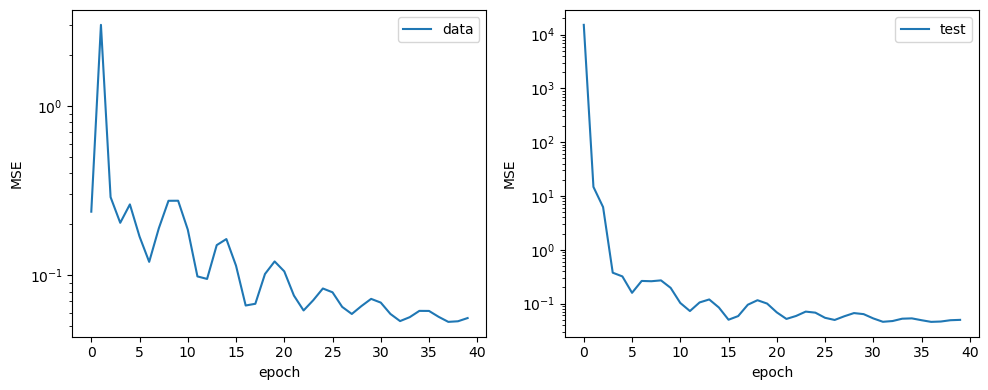

In [7]:
fig, (ax1, ax2) = plt.subplots(figsize=(10, 4), ncols=2)

# ax1.plot(losses_ic, label="ic")
# ax1.plot(losses_bc_value, label="bc_value")
# ax1.plot(losses_bc_derivative, label="bc_derivative")
# ax1.plot(losses_pde, label="pde")
ax1.plot(losses_data, label="data")
# ax1.plot(losses_train, label="train")
ax1.legend()
ax1.set_yscale("log")
ax1.set_xlabel("epoch")
ax1.set_ylabel("MSE")

ax2.plot(losses_test, label="test")
ax2.legend()
ax2.set_yscale("log")
ax2.set_xlabel("epoch")
ax2.set_ylabel("MSE")

fig.tight_layout()
fig.show()

In [9]:
exp_id = 1
result_dir = Path("result") / f"{exp_id}"

# result_dir.mkdir()
# with open(result_dir / "learning_rate.yaml", "w") as f:
#     yaml.safe_dump(lr, f)
# checkpoint = {
#     "best_model_state_dict": model.state_dict(),
#     "ic": losses_ic,
#     "bc_value": losses_bc_value,
#     "bc_derivative": losses_bc_derivative,
#     "pde": losses_pde,
#     "data": losses_data,
#     "train": losses_train,
#     "test": losses_test,
# }
# torch.save(checkpoint, result_dir / "model.pth")


# with open(result_dir / "learning_rate.yaml", "r") as f:
#     lr = yaml.safe_load(f)
# print(lr)
# checkpoint = torch.load(result_dir / "model.pth")
# model.load_state_dict(checkpoint["best_model_state_dict"])
# losses_ic = checkpoint["ic"]
# losses_bc_value = checkpoint["bc_value"]
# losses_bc_derivative = checkpoint["bc_derivative"]
# losses_pde = checkpoint["pde"]
# losses_data = checkpoint["data"]
# losses_train = checkpoint["train"]
# losses_test = checkpoint["test"]

<All keys matched successfully>

# Test

In [8]:
num_batch = 4
num_steps = xyt.shape[2]  # [Ny+1, Nx+1, S+1, 3] -> S+1

pred_trajectories = []
with torch.no_grad():
    model.eval()

    for batch in range(num_batch):
        start = int(num_steps / num_batch * batch)
        end = (
            int(num_steps / num_batch * (batch + 1))
            if batch < num_batch - 1
            else num_steps
        )

        xyt_batch = xyt[:, :, start:end].to(device).reshape(-1, 3, 1)
        prediction = model(xyt_batch[:, 0], xyt_batch[:, 1], xyt_batch[:, 2])

        # [Ny+1, Nx+1, batch_step, 2]
        pred_trajectories.append(
            prediction.reshape(trajectory.shape[1], trajectory.shape[2], -1, 2)
        )

# [S+1, Ny+1, Nx+1, 2]
pred_trajectory = torch.cat(pred_trajectories, dim=2).permute(2, 0, 1, 3).cpu().numpy()
true_trajectory = trajectory.cpu().numpy()

In [9]:
error = true_trajectory - pred_trajectory
print(f"MAE={np.abs(error).mean():.4e}, in range {error.min(), error.max()}")

MAE=1.4476e-01, in range (-1.3670325, 1.0354482)


In [16]:
error = true_trajectory - pred_trajectory
print(f"MAE={np.abs(error).mean():.4e}, in range {error.min(), error.max()}")

MAE=8.4502e-02, in range (-0.47358733, 0.5026393)


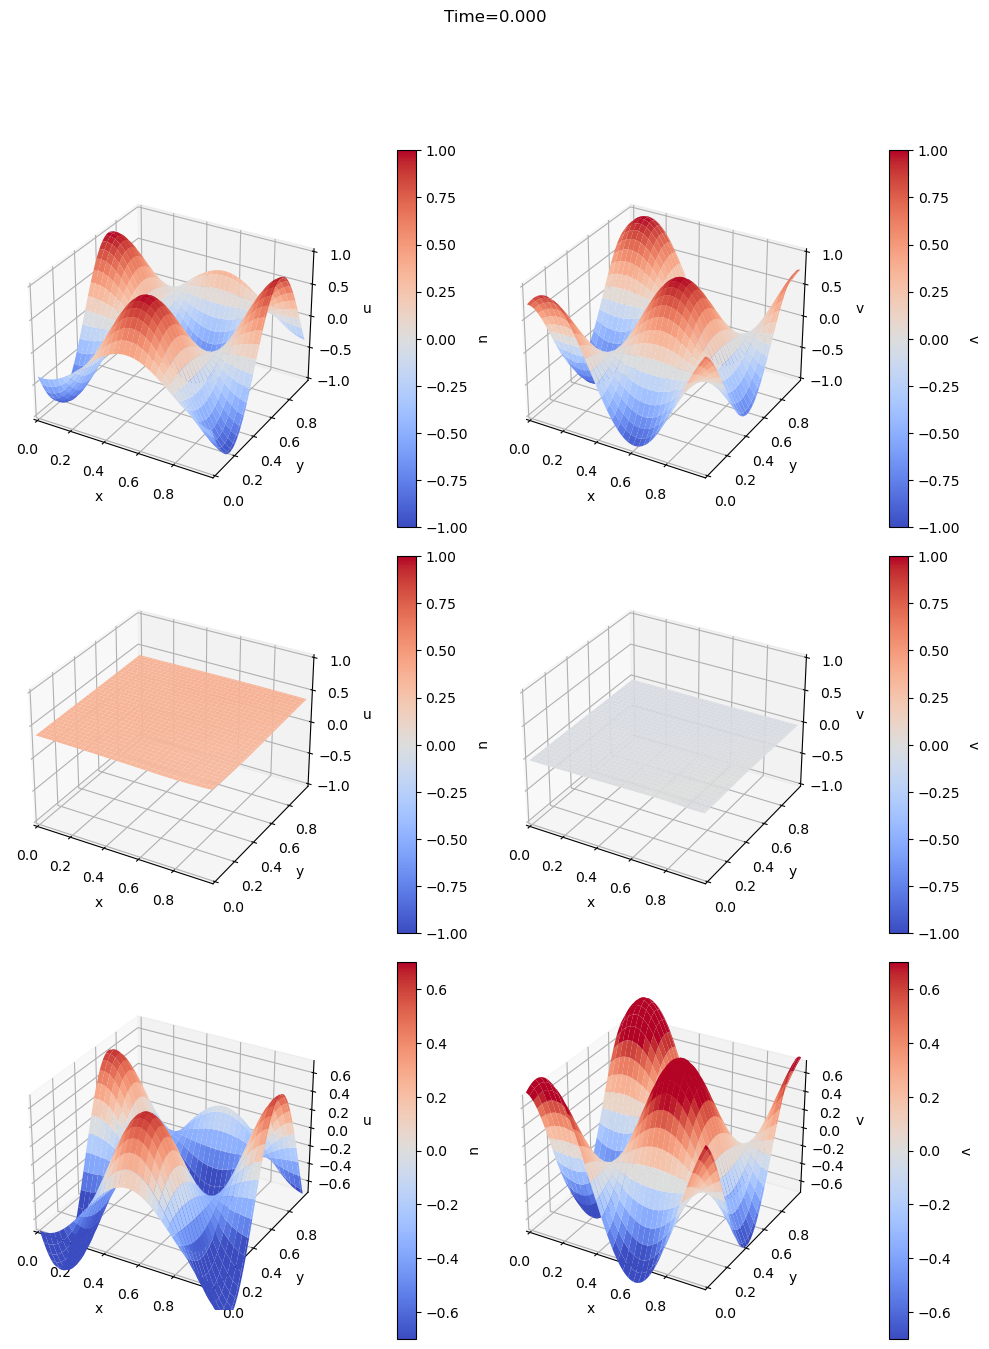

In [10]:
skip_frame = 10
position = xyt[:, :, 0, :2].numpy()
time = xyt[0, 0, :, 2].numpy()

fig = plt.figure(figsize=(10, 15))
ax1 = fig.add_subplot(321, projection="3d")
ax2 = fig.add_subplot(322, projection="3d")
ax3 = fig.add_subplot(323, projection="3d")
ax4 = fig.add_subplot(324, projection="3d")
ax5 = fig.add_subplot(325, projection="3d")
ax6 = fig.add_subplot(326, projection="3d")

ax1.set_title("True")
sf1, sf2 = plot_2d(ax1, ax2, position, true_trajectory[0], to_periodic=False)
cbar1 = ax1.figure.colorbar(sf1, ax=ax1, shrink=0.6, pad=0.15)
cbar1.ax.set_ylabel("u", rotation=-90, va="bottom")
cbar2 = ax2.figure.colorbar(sf2, ax=ax2, shrink=0.6, pad=0.15)
cbar2.ax.set_ylabel("v", rotation=-90, va="bottom")


ax3.set_title("Pred")
sf3, sf4 = plot_2d(ax3, ax4, position, pred_trajectory[0], to_periodic=False)
cbar3 = ax3.figure.colorbar(sf3, ax=ax3, shrink=0.6, pad=0.15)
cbar3.ax.set_ylabel("u", rotation=-90, va="bottom")
cbar4 = ax4.figure.colorbar(sf4, ax=ax4, shrink=0.6, pad=0.15)
cbar4.ax.set_ylabel("v", rotation=-90, va="bottom")

ax5.set_title("Error")
sf5, sf6 = plot_2d(ax5, ax6, position, error[0], to_periodic=False, lim=(-0.7, 0.7))
cbar5 = ax5.figure.colorbar(sf5, ax=ax5, shrink=0.6, pad=0.15)
cbar5.ax.set_ylabel("u", rotation=-90, va="bottom")
cbar6 = ax6.figure.colorbar(sf6, ax=ax6, shrink=0.6, pad=0.15)
cbar6.ax.set_ylabel("v", rotation=-90, va="bottom")
fig.tight_layout()


def update(frame: int) -> None:
    frame *= skip_frame
    ax1.clear()
    ax2.clear()
    ax3.clear()
    ax4.clear()
    ax5.clear()
    ax6.clear()
    plot_2d(ax1, ax2, position, true_trajectory[frame], to_periodic=False)
    plot_2d(ax3, ax4, position, pred_trajectory[frame], to_periodic=False)
    plot_2d(ax5, ax6, position, error[frame], to_periodic=False, lim=(-0.7, 0.7))
    fig.suptitle(f"Time={time[frame]:.3f}")
    fig.tight_layout()


anim = FuncAnimation(
    fig, update, frames=int(len(pred_trajectory) / skip_frame), interval=50
)
# anim.save(str(FIG_DIR / f"burgers_{test_id}_{sample_idx}_PINN_v2_{exp_id}.gif"))
anim.save(f"temp.gif")